In [1]:
from __future__ import unicode_literals

import sys
import os
from bs4 import BeautifulSoup
import urllib2
import cv2
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image, ImageDraw, ImageFont

In [2]:
# from https://stackoverflow.com/questions/4460921/extract-the-first-paragraph-from-a-wikipedia-article-python
import re
import textwrap
import yaml
import urllib
import urllib2
import random

import wikipedia

In [3]:
# set utf-8
stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
sys.getdefaultencoding()

'utf-8'


In [4]:
OUTPUT_PATH = '/home/ziweihe/sdb1/cvdata/wikipages500_3zhkoen/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [5]:
DATA_SIZE = 500
IMG_SIZE = (227, 227)

In [6]:
LANG = {
    'en': 'https://en.wikipedia.org',
    'zh': 'https://zh.wikipedia.org',
    'ko': 'https://ko.wikipedia.org'
}

In [7]:
class WikipediaError(Exception):
    pass

In [8]:
class Wikipedia:
    url_article = 'http://%s.wikipedia.org/w/index.php?action=raw&title=%s'
    url_image = 'http://%s.wikipedia.org/w/index.php?title=Special:FilePath&file=%s'
    url_search = 'http://%s.wikipedia.org/w/api.php?action=query&list=search&srsearch=%s&sroffset=%d&srlimit=%d&format=yaml'
   
    def __init__(self, lang):
        self.lang = lang
   
    def __fetch(self, url):
        request = urllib2.Request(url)
        request.add_header('User-Agent', 'Mozilla/5.0')
       
        try:
            result = urllib2.urlopen(request)
        except urllib2.HTTPError, e:
            raise WikipediaError(e.code)
        except urllib2.URLError, e:
            raise WikipediaError(e.reason)
       
        return result
   
    def article(self, article):
        url = self.url_article % (self.lang, urllib.quote_plus(article))
        content = self.__fetch(url).read()
       
        if content.upper().startswith('#REDIRECT'):
            match = re.match('(?i)#REDIRECT \[\[([^\[\]]+)\]\]', content)
           
            if not match == None:
                return self.article(match.group(1))
           
            raise WikipediaError('Can\'t found redirect article.')
       
        return content
   
    def image(self, image, thumb=None):
        url = self.url_image % (self.lang, image)
        result = self.__fetch(url)
        content = result.read()
       
        if thumb:
            url = result.geturl() + '/' + thumb + 'px-' + image
            url = url.replace('/commons/', '/commons/thumb/')
            url = url.replace('/' + self.lang + '/', '/' + self.lang + '/thumb/')
           
            return self.__fetch(url).read()
       
        return content
   
    def search(self, query, page=1, limit=10):
        offset = (page - 1) * limit
        url = self.url_search % (self.lang, urllib.quote_plus(query), offset, limit)
        content = self.__fetch(url).read()
       
        parsed = yaml.load(content)
        search = parsed['query']['search']
       
        results = []
       
        if search:
            for article in search:
                title = article['title'].strip()
               
                snippet = article['snippet']
                snippet = re.sub(r'(?m)<.*?>', '', snippet)
                snippet = re.sub(r'\s+', ' ', snippet)
                snippet = snippet.replace(' . ', '. ')
                snippet = snippet.replace(' , ', ', ')
                snippet = snippet.strip()
               
                wordcount = article['wordcount']
               
                results.append({
                    'title' : title,
                    'snippet' : snippet,
                    'wordcount' : wordcount
                })
       
        # yaml.dump(results, default_style='', default_flow_style=False,
        #     allow_unicode=True)
        return results

In [9]:
def unwiki(wiki):
    """
   Remove wiki markup from the text.
   """
    wiki = re.sub(r'(?i)\{\{IPA(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'(?i)\{\{Lang(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\|[^\{\}]*?\|\}', '', wiki)
    wiki = re.sub(r'(?i)\[\[Category:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[Image:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[File:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'\[\[[^\[\]]*?\|([^\[\]]*?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', '', wiki)
    wiki = re.sub(r'(?i)File:[^\[\]]*?', '', wiki)
    wiki = re.sub(r'\[[^\[\]]*? ([^\[\]]*?)\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r"''+", '', wiki)
    wiki = re.sub(r'(?m)^\*$', '', wiki)

    return wiki

def unhtml(html):
    """
   Remove HTML from the text.
   """
    html = re.sub(r'(?i)&nbsp;', ' ', html)
    html = re.sub(r'(?i)<br[ \\]*?>', '\n', html)
    html = re.sub(r'(?m)<!--.*?--\s*>', '', html)
    html = re.sub(r'(?i)<ref[^>]*>[^>]*<\/ ?ref>', '', html)
    html = re.sub(r'(?m)<.*?>', '', html)
    html = re.sub(r'(?i)&amp;', '&', html)

    return html

def punctuate(text):
    """
   Convert every text part into well-formed one-space
   separate paragraph.
   """
    text = re.sub(r'\r\n|\n|\r', '\n', text)
    text = re.sub(r'\n\n+', '\n\n', text)

    parts = text.split('\n\n')
    partsParsed = []

    for part in parts:
        part = part.strip()

        if len(part) == 0:
            continue

        partsParsed.append(part)

    return '\n\n'.join(partsParsed)


In [10]:
def article_urls_crawl(prefix, root_url, count):
    atc_list = set([])
    link_list = set([root_url])
    while True:
        url = random.choice(tuple(link_list))
        try:
            content = urllib.urlopen(url)
        except:
            continue
#         print urllib.urlopen(url).headers.getheader('Content-Type')
        soup = BeautifulSoup(content, "html.parser")
        base=soup.find('div', id="bodyContent")

        for link in BeautifulSoup(str(base), "html.parser").findAll("a"):
            if 'href' in link.attrs:  # Make sure it is link
                if link['href'].startswith('/wiki/') and prefix + link['href'] != url:
                    link_list.add(prefix + link['href'])
                if ( 
                    link['href'].startswith('/wiki/') and  # Make sure it is a wiki page
                    len(link['href'].split('/')) == 3 and  # Make sure it is an article
                    len(link['href'].split(':')) == 1      # Make sure it is not category
                ):
#                     print(link['href'])
                    title = str(link['href'])
                    title = urllib.unquote(title).decode('utf8')
                    print title
                    atc_list.add(prefix + title)
                    if len(atc_list) == count:
                        print('fetched ' + str(count) + ' article urls from ' + prefix + '\n')
                        return atc_list

urls_by_lang = {}

for key in LANG:
    urls_by_lang[key] = article_urls_crawl(LANG[key], LANG[key], DATA_SIZE)

/wiki/한국어_위키백과
/wiki/해달
/wiki/북태평양
/wiki/해양_포유류
/wiki/족제비과
/wiki/성게
/wiki/연체동물
/wiki/갑각류
/wiki/물고기
/wiki/성게
/wiki/알류샨_열도
/wiki/캘리포니아
/wiki/해달
/wiki/과학적_방법
/wiki/현상
/wiki/지식
/wiki/지식
/wiki/경험
/wiki/측정
/wiki/진리
/wiki/철학
/wiki/종교
/wiki/수학
/wiki/과학계
/wiki/동료평가
/wiki/과학_이론
/wiki/과학적_방법
/wiki/8월_24일
/wiki/우크라이나
/wiki/독립기념일
/wiki/79년
/wiki/이탈리아
/wiki/베수비오_화산
/wiki/폼페이
/wiki/헤르쿨라네움
/wiki/화산재
/wiki/1456년
/wiki/인쇄기
/wiki/구텐베르크_성경
/wiki/1572년
/wiki/성_바르톨로메오_축일의_학살
/wiki/프랑스
/wiki/위그노
/wiki/학살
/wiki/1954년
/wiki/브라질의_대통령
/wiki/제툴리우_바르가스
/wiki/2006년
/wiki/국제천문연맹
/wiki/체코
/wiki/프라하
/wiki/행성
/wiki/명왕성
/wiki/픽사
/wiki/새들의_이야기
/wiki/몬스터_주식회사
/wiki/핀란드
/wiki/핀란드의_사형제
/wiki/핀란드_헌법
/wiki/홀랜드_(가수)
/wiki/동성애자
/wiki/커밍아웃
/wiki/텔러-울람_설계
/wiki/수소폭탄
/wiki/핵출력
/wiki/조선민주주의인민공화국
/wiki/중화인민공화국
/wiki/압록강
/wiki/조선민주주의인민공화국-중화인민공화국_국경
/wiki/압록강_단교
/wiki/한국_전쟁
/wiki/유엔군
/wiki/위키백과
/wiki/위키
/wiki/월드_와이드_웹
/wiki/백과사전
/wiki/자유_콘텐츠
/wiki/8월_19일
/wiki/인도네시아
/wiki/롬복섬
/wiki/2018년_8월_19일_롬복섬_지진
/wiki/8월_18일
/wiki/자카르타
/wiki/팔렘

/wiki/English_(disambiguation)
/wiki/English-speaking_world
/wiki/Second_language
/wiki/Foreign_language
/wiki/Language_family
/wiki/Indo-European_languages
/wiki/Germanic_languages
/wiki/West_Germanic_languages
/wiki/Anglo-Frisian_languages
/wiki/Anglic_languages
/wiki/Old_English
/wiki/Middle_English
/wiki/Early_Modern_English
/wiki/Writing_system
/wiki/Latin_script
/wiki/English_alphabet
/wiki/English_Braille
/wiki/Unified_English_Braille
/wiki/Manually_coded_language
/wiki/Manually_coded_English
/wiki/List_of_territorial_entities_where_English_is_an_official_language#Sovereign_states
/wiki/List_of_territorial_entities_where_English_is_an_official_language#Non-sovereign_entities
/wiki/United_Nations
/wiki/European_Union
/wiki/Commonwealth_of_Nations
/wiki/Council_of_Europe
/wiki/International_Criminal_Court
/wiki/International_Monetary_Fund
/wiki/International_Olympic_Committee
/wiki/International_Organization_for_Standardization
/wiki/NATO
/wiki/WTO
/wiki/North_American_Free_Trade_

/wiki/自由內容
/wiki/天津历史文化街区列表
/wiki/天津市
/wiki/天津歷史
/wiki/天津租界
/wiki/天津市区
/wiki/法国
/wiki/意大利
/wiki/英国
/wiki/波特兰森林公园
/wiki/乐声安峰
/wiki/福克兰群岛
/wiki/欧洲超级杯冠军主教练列表
/wiki/欧洲冠军联赛冠军主教练列表
/wiki/阿積士四角賽
/wiki/台灣
/wiki/澎湖
/wiki/風櫃威武金王殿
/wiki/萬善爺
/wiki/美國總統
/wiki/唐納德·特朗普
/wiki/英國
/wiki/倫敦
/wiki/愛丁堡
/wiki/唐納德·特朗普寶寶氣球
/wiki/李季伦
/wiki/中国农业大学
/wiki/石元春
/wiki/2018年颶風赫克托
/wiki/颶風吉納維芙_(2014年)
/wiki/熱帶氣旋
/wiki/魏晋南北朝
/wiki/子夜歌
/wiki/晋朝
/wiki/台灣
/wiki/澎湖
/wiki/吳克文
/wiki/瓦爾特·馮·賴歇瑙
/wiki/納粹德國陸軍
/wiki/德国元帅
/wiki/第二次世界大战
/wiki/阿道夫·希特勒
/wiki/纳粹党
/wiki/冲锋队_(纳粹党)
/wiki/军_(军队)
/wiki/軍團
/wiki/集团军
/wiki/苏德战争
/wiki/乌克兰族
/wiki/白俄罗斯人
/wiki/格特·馮·倫德施泰特
/wiki/南方集團軍
/wiki/心脏病
/wiki/让-米歇尔·雅尔
/wiki/法国
/wiki/里昂
/wiki/電子音樂
/wiki/澳洲自由黨
/wiki/斯科特·莫里森
/wiki/麥肯·滕博爾
/wiki/澳洲總理
/wiki/2018年中華民國邦交國斷交與代表機構更名事件
/wiki/中華民國與薩爾瓦多關係
/wiki/中国－萨尔瓦多关系
/wiki/懶人小鎮
/wiki/斯特凡·卡爾·斯蒂芬森
/wiki/穆罕默德六世_(摩洛哥)
/wiki/徵兵制
/wiki/摩洛哥议会
/wiki/尼古拉斯·马杜罗
/wiki/委內瑞拉玻利瓦
/wiki/石油币
/wiki/2018年8月逝世人物列表
/wiki/薩杜·哈亞圖
/wiki/科菲·安南
/wiki/鮑勃·巴斯
/wiki/艾瑞莎·弗蘭克林
/wiki/8月24日
/wiki/乌克

In [11]:
def getChinese(context):
    context = context.decode("utf-8") # convert context from str to unicode
    filtrate = re.compile(u'[^\u4E00-\u9FA5]') # non-Chinese unicode range
    context = filtrate.sub(r'', context) # remove all non-Chinese characters
    context = context.encode("utf-8") # convert unicode back to str
    return context

Заглавная_страница


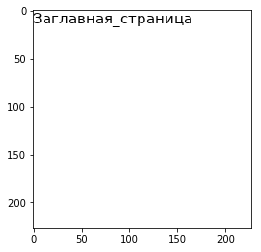

In [12]:
text = "Заглавная_страница"
print text
image = Image.new('L', IMG_SIZE, 255)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSans.ttf', 15)
margin = 0
offset = 0
for line in textwrap.wrap(text, width=23):
    draw.text((margin, offset), line, font=font, fill="#000000")
    offset += font.getsize(line)[1]
plt.imshow(image)

In [13]:
def generate_imgs(langs, urls_by_lang, count, fontsizerange):
    for key in langs:
        print 'generating imgs for ' + key
        i = 0
        while i < count:
            wikipedia.set_lang(key)
            res = None
            title = random.choice(tuple(urls_by_lang[key])).split('/')[-1].replace('_', ' ')
            try:
                res = wikipedia.summary(title)
            except:
                print "fetch failed for " + title
                continue
            
            text = ""
            if key == 'ko':
                for n in re.findall(ur'[\u3131-\ucb4c]+',res):
                    text = text + n
            elif key == 'en':
                for n in re.findall(ur'[a-zA-Z]+',res):
                    text = text + n
            elif key == 'zh':
                for n in re.findall(ur'[\u4e00-\u9fff]+',res):
                    text = text + n
            elif key == 'ru':
                for n in re.findall(ur'[\u0400-\u04ff]+',res):
                    text = text + n
            print text


            fontsize = random.randint(fontsizerange[0], fontsizerange[1])
            fontwidth = IMG_SIZE[1]/(fontsize/3*4)*3

            image = Image.new('L', IMG_SIZE, 255)
            draw = ImageDraw.Draw(image)
            if key == 'ko':
                font = ImageFont.truetype('/home/ziweihe/fonts/NanumSquareB.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=fontwidth):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            elif key == 'en' or key == 'ru':
                font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSans.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=fontwidth):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            elif key == 'zh':
                font = ImageFont.truetype('/home/ziweihe/fonts/msyh.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=fontwidth):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            image.save(OUTPUT_PATH + key + '-' + str(i) + '-wiki.jpg')
            i += 1

In [ ]:
generate_imgs(LANG, urls_by_lang, DATA_SIZE, (60, 60))

generating imgs for ko
솔안널은강원도백시동동백산역인근과강원도삼시도계읍전리도계역인근을잇는영동선의루식널이다
력核出力영어은무기가발였을때나오는에너지의양으로주로산상로메가또는라줄등의단위로산다일례로로시마에된리보이의력은에서정도였다역사상가장막강력의무기는소련이년실르봄바로의위력을가졌다러울람설계와같이단계적으로설계된열무기의경우물질만분다면이론상가능력은제이없다그러나력의규모가지면두의질량과기도그만져서운반기곤란지고목물을괴는것을과는위력의무기는득보다실이많기때문에전술적전략적용성을고려과도력의무기는실전용으로제작되지않는다
린영어순용어인쇄기는그것이연결된에저장된데이의드복사본보종이에인쇄되는스은그래를만드는력장이다대민국에서는린기라는말도쓰이지만린라는용어자가인쇄는기계라는뜻이되므로이는잘못된이다과거전사린도매릭스린등이쓰였으나재는잉젯린레이저린가널리쓰인다넓은의미에서는린와같은종이인쇄력물이아닌전자문서력물을력는가상의린에뮬레이도린의정의에된다
력核出力영어은무기가발였을때나오는에너지의양으로주로산상로메가또는라줄등의단위로산다일례로로시마에된리보이의력은에서정도였다역사상가장막강력의무기는소련이년실르봄바로의위력을가졌다러울람설계와같이단계적으로설계된열무기의경우물질만분다면이론상가능력은제이없다그러나력의규모가지면두의질량과기도그만져서운반기곤란지고목물을괴는것을과는위력의무기는득보다실이많기때문에전술적전략적용성을고려과도력의무기는실전용으로제작되지않는다
에도막부일본어江戶幕府또는도가와막부徳川幕府는일본사에서가마라막부무로마막부에이어일본사에서세번째로나난의막부이다년월일게이년음력월일에도가와이에야스가쇼군征夷大将軍세이이이쇼군에임고막부를설였을때부시작되어년월일게이오년음력월일에대쇼군인도가와요시노부가대정봉이라는이름으로정권을에게넘기게된것으로막을내렸다도가와가문의쇼군들이일본을지배이년간의시기를에도시대또는도가와시대라다에도막부는바幕藩제밑에사농공상의신분을고정고기독교금지를구실로쇄국을고에는유교적교도이용면서전국지배를강다조선에대서는년부년까지신사를여두세기동안양국간의밀접교류를였다에도시대말기막부도운동이융성였던격동의시기는막말幕末바마쓰이라다
정測定은일정기준을가지고물건의양을수는작업을말다정은단위를정여비교

네의국기는세계에서유일게사각모양이아닌국기로위아래양쪽으로삼각두개를놓은를고있다세로가가로보다더긴유일국기이기도다년에제정된의국기는사람의얼굴상이그려진양의깃발과음의깃발이별도로제정되었다년에는재와비슷의국기가제정되었는데얼굴상은지워지지않았다년월일새로운네법이제정됨에따라새정부가범면서재의국기로수정되었다란색두리는를의미며빨간색은네을상징는색이다양과달은양과달이존재는네도존재다는것을명과동시에음의왕조를의미다년군주제가지되고공국이수립된이에도계속사용된다
전면黃田面은전라남도순시북쪽에위면이다구례로는길목에있어이곳을지나는도역중에구례구역이라는이름의역이있다
국어韓國語또는조선말朝鮮말은대민국과조선민주주의인민공국의공용어로대민국에서는국어라고부르고조선민주주의인민공국에서는조선말중인민공국과일본에서는조선어朝鮮語라고부르며러시아와중앙아시아의고려인들사이에서는고려말高麗말이라고부른다세기중반이반도와주변정세의란세기전반일본제국의략세기반대민국의외이민등의요인으로중인민공국일본러시아우즈베스미국나다오스레일리아리베남등세계여러지역에민족이이주면서이들민족이거주는지역에서도국어가사용되고있다년월기준으로국어사용인구는약만명으로산된다
멜론뮤직어워드약는온라인음악사이의사인의주로진되는음악시상식이다년부년까지온라인상으로시상을다가년부오라인으로음시상식이개되었다
물고기또는어류魚類는동물아문에속는동물의나이다동물중에서네발동물은제외된다대적으로물속에살며아가미로며지느러미로움직이고몸면이비늘로덮여있으며냉동물로주위온도에영을받는다물고기는지구상의여러수생경에서분며그서식지는열대지방에서극권내륙의담수지역에서수지역또양의에서깊은바다에까지이르는등다양다어류전의종수는정도이며이는동물전의과반수에당다국에서는생선이라고불리기도는데이는보음식으로분류된이름이다상업적이고자급자족을는어부들은생선을야생에서직접잡든지아니면수나바다의우리에서길러낸다오락으로낚시광들에게많이잡며물고기애가들은잡아서우기도다여러세기에걸물고기는문적인역도담당왔다신이나종교적기로서앙받기도였고예술영의주제로도쓰였다
도鐵道는궤도와륜의마을주방식으로는광범위운송수단을일는말이다원적으로는는개의제레일상을런지등조기능이부가된륜을이용여주는운송수단을의미나법률이나기용례에따라서는전용의궤도계위를운는운송수단의

갑각류甲殼類는절지동물의분류로게와새우따개비등여종의생물이갑각류무리에속다갑각아문甲殼亞門으로분류다수중생을는것들이많으며자유롭게엄거나바닥을기어다니면서생는것이보이지만수중의부유물에고거나어류나기무동물에게기생는경우도있고일부는부유생을기도다주로온대에서열대에걸수심까지의얕은바다나민물에서식며극지방이나수심이상의깊은바다에서식는종도있다민물에사는종중에는이상의높은산이나동굴지수에서생는것도있다따개비류등의몇몇을제외면대부분암수딴몸으로서부유유생을거변끝에성로자란다경제적인면에서갑각류는수산자원이나어류의연사료등으로사용되어수산업면에서인간에게많은도움이되고있다
자아연의사원제은미국의사자어빙고만이년에저술고년개정된사서적이다어빙고만은이의심아이디어를자신의박사위논문에서부발전시다이은세기반의가장영력있는사자로가받는어빙고먼의저서로연극으로서의사적삶을다양자료를바으로섬세게분석이다자아연의사에서고만은직접대면는상작용에서발생는연극적동을묘사다그는개인이다른사람과접때자신의경외모도를바꿈으로써다른사람이자신을상다는인상을제거나안내려고시도다고주장다또고만은사적상작용여자들이그들자신이나다른사람들을당게만드는것을기위정관에여다고믿었으며고만은연극공연에서와마가지로사적상작용에는배우개인가관객앞에등장는무대구역이있으며이곳은긍정적자아개념과바람직인상이제공되는곳이다그러나무대뒤에는그들이자연스럽게동수있고그들의사적역과정성을떨어릴수있는숨겨진개인의구역이있다고보았다어빙고만은우리의일상적삶은세상이라는무대에서다른사람들과상작용면서자아를연는공연과같다는관점을제시다고만은우리에게익숙일상적삶을미경으로들여다보듯꼼꼼게관고우리가당연받아들이는미세삶의모습을날로운력으로밀게분석낸다이은어빙고만의의가장유명으로그는이으로년에미국사의매버상을수여받았다년국제사는이을세기가장중요사선의목록에올렸다
남아메리스인어르갈어영어또는남미南美는서반구에위대륙으로대부분남반구에위있고일부분은북반구에걸있다북쪽으로는나마지을북아메리와연결되며서쪽에는양북동쪽에는대서양남쪽에는남극와접다아메리란이름은년지도제작자마르발제뮐러와마아스링만이아메리대륙이동인도가아닌신세계임을주장의유럽인인아메리고베스이름에서지은데서나온말이다남아메리대륙의면적은방로미로지면의약를지다년기준이대륙의인구는약억만명이상으

면面은대민국의자시군또는정시의부정구역이름이다과거조선에서도정구역명으로사용되었다조선민주주의인민공국에서는년월에실시된군면리대에따라모든면이지되었다
남북국시대南北國時代는년는년에유득공에의조된북부의만주와연주를중심으로발의건국이남부의반도에있는신라와공존던시대를일는역사용어이다년에남국인신라가분열삼국되면서남북국는깨어지기시작였고년에북국인발가요나라에게망면서그의미를완전상실였다일각에서일신라시대統一新羅時代라는을사용는경우가있는데신라는국가가성립된이래로역사적동질성을부여수있는주변국가나영역을단번도일적이없다이는당시신라인들의인식을잘반영고있는사관이다고구려백제신라인들사이에민족의식이성되기시작것은삼국전쟁이삼일이라는로간다를내세우면서부이기때문에당대신라인백제와고구려유민에게는삼일이적다
도넛영어문어가락지빵은소맥분에설버달걀등을고기름으로긴식이다도넛은작은전문점이나수마의점리아등에서매된다
작별作別은년월일부년월일까지방영된월드라마로월드라마사상음으로외주제작삼로덕션여제가됐다
년은수요일로시작는년이다
랑또는색靑色은가량의장을갖는색이다빛의굴절률이번째로색이며굴절률이두번째로색은록이다
신세계백점센시는대민국에있는세계대규모의백점으로주식사신세계가운영고있다주소는부산광역시운대구센남대로이다도심속의양지를방여쇼시설외에도질방아이스링영관골연습장드전망대쇼몰서점옥상공원등의시설을갖고있다
이는고대로마의도시이다이리아남부니아주나리인근으로재정구역으로는이무네에속다년월일베수비오산분로인근의르라네움등과께산재와분석에묻괴되었다농업과상업의중심지이자로마귀족들의양지였다
백과사전百科事典라어은문기술예술등자연과인간의모든동에관다방면의지식을수집여계적으로정리이다백과사전의영어명는그리스어의와의결을어원으로가지고있는데온갖종류의지식을가르기른다는뜻이다즉백과사전의원래목적이교육이었다백과사전의또다른목적으로는고가있다대의백과사전들은교육과고모두를목적으로는경우가많다백과사전에서내용분류의단위이자설명의대상이되는것을제어라고다제어의범위에따라백과사전의종류가나뉘는데넓은범위를갖는제어들로백과사전을구성는것을대목주의라고고상대적으로좁은범위의제어를이용는것을소목주의고다대목주의는나의주제에대깊이있고괄적으로설명는방식으로교육목적의백과사전이유명자의논문을모아서엮는방

잉글랜드구국가대은잉글랜드를대는구국가대이다년잉글랜드구가설되었으며년자국에서열린월드에서음으로월드우승을이뤘다년월드에서는위의성적을내기도고년러시아월드에서는강전에서스웨덴을으로꺾고년만에강에진으나로아아에강전에서로고위전에서도벨기에에로위에머물렀다유럽선수권대에서는유로때강에진적이있다
조선민주주의인민공국朝鮮民主主義人民共和國영어은동아시아의반도북부에위국가이다수도는양직시이며남쪽으로는대민국과북쪽으로는중인민공국및러시아와접고있다공용어는국어이며양말과같은서북방언에기문어를준어로삼고있다년제세계대전이끝나고반도의북위도이북지역에서소련군에의군정이실시되었으며년월북조선임시인민위원가수립되었다그로부년뒤인년에는반도선거에기여김일성을수상박영명등을부수상으로여년월일조선민주주의인민공국이공식적으로범다년월일부일간열린고인민의에서과된조선민주주의인민공국사주의법에따르면국가원수는상임위원장이었고이자리에는김두봉이선되었다당시김일성은국가원수가아닌내각의수상으로선되었다식상의다당제제이지만사실상조선로동당의당독재제이며국가주석김일성의아들김정일그리고김일성의손자이자김정일의아들인김정은이례로집권여세습에의독재국가라는비이있다주사상은년사주의법개정에서로등장였고년월법개정때소비에연방의기가되는마르스레닌주의를삭제고그자리를대신게되면서조선민주주의인민공국의독자적인사주의계를마련다년사주의법개정때공산주의문구를전부삭제고국방위원장의권을대강여국방위원장이자국의실권자임을명시다년월에는법이나노동당규약보다상위규범인당의유일사상계립의대원이년만에개정되면서당의유일적영도계립의대원으로이름이바뀌었고사주의공산주의관련내용을완전삭제고주사상으로대으며김일성가문의백두계승을명문다
대민국의일본대중문개방은대민국의자국문의보를위또일본제국의국병의영에의국민감정을는등의이유로일본의만나영음악등대중문를법으로규제왔으며대민국정부가례간개방을것을말다규제것의구적인예로는에서일본노래를어주는것을금지거나일본애니메이션방송금지등이있다그러나근점제을완고있다대민국정부는례간개방을이루었다
란드군란드어은란드공국의국군이다지상군공군군수군으로이루어져있다

개미는벌목개미과준어개밋과에속는곤의으로말벌벌과더불어벌목에속다개미는억만여년에서억만여년전백악기중반에말벌과비슷조상에서진여속씨식물이등장

에도막부일본어江戶幕府또는도가와막부徳川幕府는일본사에서가마라막부무로마막부에이어일본사에서세번째로나난의막부이다년월일게이년음력월일에도가와이에야스가쇼군征夷大将軍세이이이쇼군에임고막부를설였을때부시작되어년월일게이오년음력월일에대쇼군인도가와요시노부가대정봉이라는이름으로정권을에게넘기게된것으로막을내렸다도가와가문의쇼군들이일본을지배이년간의시기를에도시대또는도가와시대라다에도막부는바幕藩제밑에사농공상의신분을고정고기독교금지를구실로쇄국을고에는유교적교도이용면서전국지배를강다조선에대서는년부년까지신사를여두세기동안양국간의밀접교류를였다에도시대말기막부도운동이융성였던격동의시기는막말幕末바마쓰이라다
중앙아시아中央또는중부아시아中部는아시아의심지역중나로서쪽으로스부동쪽으로는중인민공국까지북쪽으로는러시아부남쪽으로는아가니스에이르는지역이다스이붙는여러국가들이이곳에산재있는데스은르시아어로의땅이라는의미를지니고있다중앙아시아는넓은범위로보았을때유라시아대륙의일부로된다대적의미에서중앙아시아는옛소련의개공국을지고있다자스르기스스지스르메니스우즈베스이중앙아시아에되는국가로인구는년에서년사이의기준으로약만명이다인구가만명인아가니스도중앙아시아에가끔된다이는지정적범주에서본중앙아시아로유네스에서정의중앙아시아의범위는이보다씬넓은지역을다중앙아시아에대정범위에대다양정의가존재지만어떠정의가일반적으로받아들여지고있지는않다경계에대명범위가없음에도이지역은전반적으로유사성을실질적으로가지고있다나를예로들자면중앙아시아사람들은비단길과유목민의역사와밀접관련을맺고있다이에따라중앙아시아는유럽과아시아대륙을사이의사람물자그리고문의이동로역을왔다
르라네움은고대로마의도시로재이리아니아주에르라노에위다재는유적의일부가유료로공개되고있다이스비아에오론스와께서기년월일에시작된베수비오산의분에의없어진것으로유명다
구스세아돌스웨덴어년월일년월일재위년월일년월일는스웨덴의국왕이다
몽유도원도夢遊桃源圖는년월일안대군이무릉도원의꿈을꾸었고그내용을안견에게설명여일만에그림이완성되었으며매죽에서몽유도원도라는제서題書를달았다이그림의은꿈속도원을위에서내려다본부감법俯瞰法으로기암절벽위에복사꽃이만발고띠로엮은막과수아래빈배도보이는꿈속의낙원을안견安堅의걸작이다
공제共和制는주권이국민에게있는정이

대제국의실大韓帝國皇室은조선왕실의계로대제국의성립때부일병조약으로멸망때까지실질적인실의주인이었다일제강점기가종료된대제국은복원되지않았지만그손들은대민국에서전주이씨대동종약원을족의계보를유지고있다상징적이긴나재까지순종제이대째대제국실수장이내려오고있다년고종제의손자이구가사망자종약원은의왕의손자이원을손이구의양아들로입적여사손皇嗣孫의지위로대제국의실수장을계승게였다일제강점기에는이왕가李王家라고였는데이는년일병조약이대제국실을왕공족의일개가문으로격여부르는명이었다때때로조선왕실과동일의미로쓰이는경우도있다는대제국실및실제소유던상등의을기준으로며일병이전의시점에대서는대제국제및족으로서의당시로며요경우괄안에묘나시사를병기다년의소위일병조약의제조에는일본국제는국제제자전및그비및예를각기지위에상응는존위엄및명예를유고또이를유지에분세비를공급것을약조다라고명문되어있어대제국의제에게제였을때에준는등을규정게되어있었다제조는그외의국족에관유사규정이조약에의일본은대제국족의신분을일본왕족에준는왕공족으로규정였다이왕공족신분의법률적근거는일본제국이제세계대전에서전이년월일일본국법이시되면서소멸으며년일기본조약에서년일병조약의무를인다
경복궁景福宮은대민국서울세종로에있는조선왕조의법궁法宮정궁이다년조년에건였다경복景福은시경에나오는말로왕과그자손온백성들이성대의복을누리기를원다는의미다수지리적으로도백악산을뒤로고좌우에는낙산과인왕산으로둘러싸여있어길지의요건을갖고있다년임진왜란으로인불이그임무를덕궁에넘겨주었다가년고종년에선대원군의명으로중건되었다일제강점기에는조선독부건물을짓는등많은전각들이손되었으나년대부독부건물을거는등복원사업을벌인덕분에복원작업은재부분완료된상다근정전경루원정아미산굴뚝등은손되지않고그대로남아있습니다면적은이며동서남북규모로남아있다
국제단위계國際單位系랑스어약는도량의나로단위계이라고도불린다국제단위계는각국가별로상이게적용는단위를미법을기준으로재세계적으로일상생뿐만아니라상업적으로나과적으로널리쓰이는도량이다전세계적으로단일된국제단위계를만드려는노력으로년월제국제도량에서가결정되었다단위는국제단위계를의미는랑스어의약자이다이당시국제단위계의계를접두어유도단위및가단위에대립였다단위는개의기본단위미로그램암어빈몰델라개의보조단위라디안스라디안와이들로부유도되는


일본어에비에이국어에이이비에이에이이비에잇은아모야스시의로듀스에의년에결성된일본의여성아이돌그룹이다덴라재돈가배로있으며관동연신이사가있다좁은의미로는일본도도아바라를근거지로써동는동명의그룹만을지고넓은의미로는나고야오사규슈니가세우및외의인도네시아자르국방중민국이이시리마닐라중인민공국상이시인도뭄바이베남민시를거점으로동는모든자매그룹까지섭렵며이경우대중매등에서는관습적으로그룹은그룹이라는용어를사용고있다이곳에서는좁은의미의및넓은의미의를모두다루고있으며넓은의미의의경우에는관습에따라그룹이라지다은만나러갈수있는아이돌을셉로여아바라의극장을그들의전용극장으로삼아거의매일공연을고있다이로써대중매를서만접수있던머나먼존재였던아이돌을가까이에서느끼도록며들에게그성장과정을여과없이공개고그들과께성장고있다년및년연말에발된오리연간싱글랭에서는그에발다섯장의싱글이모두위부위를지으며이에따라제및제일본레드대상에서라잉겟과여름의으로년연속대상을수상였고그이듬에열리는제및제일본골드디스대상에서도년연속으로국내음악부문아스오브더이어를수상였다년월일에발된번째싱글안녕롤은년연간기준으로만장의매량을기록고있는데이는여름의이기록만장을뛰어넘는자싱글매량고기록이며년월에발매된의싱글가기록고있었던만장까지뛰어넘으며역대여성아스단일싱글매량고기록을년만에경신게되었다이에앞선월일에는전싱글매량으로만장을기록였는데이는이때까지마사아유미가가지고있던만장을뛰어넘는싱글매량부문에서의여성아스역대다기록이다
이승만李承晩년월일음력월일년월일은조선과대제국및대민국의개언론인정인이며대민국임시정부의대령대민국의제대대령이다본관은전주대제국시절성보와독립신문주교육계몽운동으로는독립동등을면서왕정지와공국수립을도모였다는반역의죄목으로옥살이를였으며수감시절개신교로개종고어린시절불교집안에서어났고개종전까지불교였다독립정신을저술였다대제국말기사면된밀사로도미였다가실다고알려져왔으나근당시이승만은대제국정부나제의대리인이아니라일진의대리인이라고자다는주장이제기되었다린스대교에서국제정박사위를받고이와이에서인원과인교등을운영였다일제강점기에는독립운동방법을놓고의견이갈라섰을때그는국내의사정을외국에알리고양를구는외교독립론을주장였다년대민국임시정부의국무리성임시정부와각지에서수립된임시정부의수반을거년월일부년월일까지대민국

/home/ziweihe/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /home/ziweihe/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


fetch failed for 현상
백두산白頭山은조선민주주의인민공국경남도경북도산군무산군과중인민공국지린성연변조선족자주에걸있는산이다중국에서는바이산중국어간자长白山정자長白山병음장백산만주어로는골민샹얀알린만주어이라고부른다반도지역에서는민족의영산으로숭앙되었으며웅이무리명을이끌고제사를열었다는백산과동일시되기도다높이는로반도에서가장높은산이다산산머리가년중개월이눈으로덮여있는데다가색의부석浮石들이얹져있어서머리산이라는뜻으로백두산이라부르게되었다백두산의고봉은장군봉將軍峰이다이상봉우리는개로도봉쌍무지개봉석봉백운봉일봉등이있으며그밖에대각봉녹명봉문봉망등미만인봉우리도여럿있다정상에는데라인지天池가있다백두산부지리산智異山까지이르는백두대간白頭大幹은반도의기본산줄기로서모든산들이여기서뻗어내렸다여예로부민족과만주족에게성스러운산으로숭배되었고웅이신시神市를열고단군이어난성지라여겨신성시되었다또백두산은남만주북동에서서남서방으로뻗은장백산맥바이산맥의주봉이기도다
나독일은국가사주의독일노동자당나당과아돌러의년부년까지의독일을가리다나독일은일본제국이리아왕국과동맹을맺었고이들국가는제세계대전을일으국이된다나독일은제세계대전에서연국에배면서멸망다독일제제국독일어으로부르기도다
수數學은양구조공간변등의개념을다루는문이다대수은식논리를이용서공리로구성된상적구조를연구는문으로여겨지기도다수은그구조와발전과정에서는자연과에속는물리을비롯다른문들과깊은연관을맺고있다지만어느과의분야들과는달리자연계에서관되지않는개념들에대서까지이론을일반및상시수있다는이가있다고다수자들은그러개념들에대서을고적절게선된정의와공리로부의엄밀연역을서들의진위를악다수은숫자세기계산정및물리적대상의모양과움직임을상고이에논리적론을적용여나났다이런기본개념들은고대이집메소미아고대인도고대중국및고대그리스의수에서아볼수있다그리고유리드의원론에서는엄밀논증이발견된다이런발전은그뒤로도계속되어세기의르네상스에이르러서는수적발전과과적방법들의상작용이일어나명적인연구들이진되며인류문명에영을미게되었다그리고이는재까지도계속되고있다오늘날수은자연과공의뿐만아니라경제등의사과에서도중요도구로서도사용된다수을이런분야들에적용응용수은그결과로써수자의발전을이끌고새로운분야들을낳았다응용이아닌수자의아름다움과재미를구며

제리우도르넬리스바르가스르갈어년월일년월일는브라질의정인이다년년년년두례대령을지내며독재제를구으나사경제개을진면서브라질의근대에기여다바르가스는브라질남부우그란지두술주의부유집안에서어났다법대를졸업변사가됐고년주의의원이되면서정계에입문다이연방원의원재무장관을지낸년우그란지두술주지사가됐다년대령선거에마으나당선되지못다그러나그월우그란지두술주에기반을둔군인들이데를일으고그는군인들의대로임시대령으로임다년에는정식으로대령으로선됐다가격을상승시기위과잉공급된를불워브라질경제복에기여다이시기는브라질주요경제적원동력으로가격의락은브라질전경제에어려움을가져왔기에공급과수요에대리는굉장중요문제였다년대령선거에서는선거전이과열되자정국불안을이유로정부데를일으고르갈을모방이스두노부르갈어새로운제라는뜻라는이름으로전주의적인독재권력을둘렀다제세계대전직전의국제적불안을이유로이러제는정당됐다브라질은그동안주의느슨연에불과으나그의집권기간중연방의권이강됐다제세계대전에서는음에는독일과관계를맺으려으나결국연군으로전다교육개공업진노동자보여성정권인정등의업적을남겼다노동법과노동조에관련된법에관여였으며노동세를만들었다저임금제를도입였는데이는노동자들이그들의가족과의삶의존엄성을유지수있는소의임금을의미다제세계대전이끝난년월전에그를지지던군부세력이데를일으그는물러났다그는데로물러났으나여전넓은지지기반을가지고있었기때문에그월선에서연방상원의원으로당선됐다년에는다시대령선거에나가노동자와농민의지지로당선되어년월제대대령으로다시임다그러나과거와같은전제주의적인권력을사수없었고이에따라그를지지던노동자의요구를들어줄수도없었다그는이에민족주의를소면자신을정당시려다오늘날브라질대의기업인국영석유업로브라스를설립기도다그의노력에도불구고인레이션이심져국민들의생은어려워져서국민의인기를잃어갔다그리고재정문제와관련된정부내부의문이일어나자군부는사임을강요고년월자살다두례에걸년가까이대령으로재직면서브라질에서가장오랫동안집권대령으로남아있는그에대서는독재자라는가와브라질의대에기여인물이라는가가공존고있다
백과사전百科事典라어은문기술예술등자연과인간의모든동에관다방면의지식을수집여계적으로정리이다백과사전의영어명는그리스어의와의결을어원으로가지고있는데온갖종류의지식을가르기른다는뜻이다즉백과사전의원래목적이교육이

제노바이리아어제노바어영어랑스어독일어스인어갈리시아어는이리아의북부에있는지중의구도시로리구리아주의주도이다고대리구리아인들의도시였다유럽연은제노바를랑스의릴과께년유럽문수도로선정였다
고대로마古代라어이리아어영어는기원전세기경이리아중부의작은마을에서시작지중를아우르는거대제국을이룬고대문명으로고대그리스오리엔셈족서유럽게르만등문의용광로였다고대로마의문법군사제는서구유럽동구권을막론고대사의법정전쟁예술문건기술언어분야의기이됐다고대로마는수백년동안장을거듭며왕정에서과두공정으로또점제정으로변모다기원전세기경로마는지역중심지로번영던도시국가로왕정제였다기원전년경에는왕정이무너지고귀족과민계급이공정을세웠다로마인들은민과귀족간에여년이상쟁과을반복며로마유의과두정제를점진적으로이뤘다내부의신분쟁가운데도로마는외적들을복속시며마내기원전년경게누아제노바에서이리아남단까지거대동맹제를수립다로마는거기에그지않고여년간여러정복전쟁을갈리아르고등을정복고지중전역을제다기원전세기말율리우스이사르가씨를뿌리고옥비아누스에의시작된제정기의로마제국은스로마나로불리는성대를구가며라어문등그레로만문의전성기를이뤘다라야누스제시대년년에로마제국은북으로는스랜드에서남으로는아리수단까지서로는르갈의대서양연안에서동으로는스지방까지대도를이룩다오늘날면적으로산면재미국면적의에달고인구도미국의절반에약간안되는정도로산된다로마제국은기독교공인교선문제를기로서로마동로마로분됐으며이민족의략으로쇠기에접어들었다서기세기경서로마제국은멸망게르만족의여러독립국가로갈라져랑왕국신성로마제국등로마의계자를자는여서유럽의정세력들이나난다동로마제국은중세시대에비잔움제국으로발전으나년오스만르에게멸망다
구베르성경독일어또는줄성경마자린성경은세기에요네스구베르가인쇄라어불가성경이다쪽에줄로인쇄가되어있어줄성서라고부르기도다구베르의이동식자로은가장음작이라고알려져있으나사실은그렇지않으며구베르명인쇄된의시대의상징적인아이이되었다재유네스세계기록유산으로등재되어있다
로버에드윈어리년년는미국의군북극가이다북극에뜻을고여러번그린란드를조사였다년이에는북극을였다년인류로북극의극지에성조기를꽂았다고알려져왔으나년에발견된어리의새로운일지를검본결과북극점에서못미지점까지만도달것으로밝졌다북극점에도달지못것과는상관없이으로북극이깊은바다

독일연방공국獨逸聯邦共和國독일어분데스레블리도이란줄여서독일獨逸독일어도이란듣기영어저매니은중앙유럽에있는나라이다북쪽으로덴마와북발동쪽으로란드와남쪽으로오스리아와스위스서쪽으로랑스룩셈부르벨기에네덜란드와국경을맞대고있다독일영는제곱로미이며기는주로온대기를보인다인구는년기준명으로유럽연에서인구가가장많은나라이며이민자인구는미국에이어세계에서두번째로많다공용어는독일어이고소수민족어나러시아어영어소르브어덴마어리지아어도쓰인다고대에여러게르만족이살던독일땅은게르마니아로알려져있었으며년이전에관련기록이남아있다세기부게르만족의땅은년까지존속신성로마제국의중심부를이루었다세기에북독일은루교가로마가릭으로부분리된종교개의심부로자리잡았다년랑스로이센전쟁중에독일은로일을이루어근대적인국민국가가되었다제세계대전이끝나고년에독일은연군점령지경계선을따라독일민주공국동독과독일연방서독으로분단되었으나년에일되었다독일은연방제와의원내각제를공국으로개주로이루어져있다수도는국내대도시인베를린이다이나라는유엔과북대서양조약기구경제력개발기구세계무역기구유럽연의원국이다독일은오늘날유럽강대국으로명목국내생산기준으로세계위의경제대국이며구매력가기준으로는세계위이다수과수입규모는세계위이다연간개발원조액은세계위이며군비지액은위를보인다독일은생수준이높으며광범위사보장제도를이룬나라이다또독일은여러과기술분야에서선도적인위를지고있다독일연구소는전세계연구소중에서과기술이세계위이다대졸자봉은년재약유로로국가들가운데두번째로높다
롬복섬인도네시아어은인도네시아누사가라바랏주의섬이다소순다열도의일부로동쪽으로롬복을끼고발리섬이서쪽으로알라스을끼고숨바와섬이위다면적인구명년이다
음바과는정상에서고온의물이저온의물보다더빨리어는상또는그과를말다관련잡지에서는이상을인고싶은경우그과가대되는섭씨도와섭씨도의물로실것을권장고있다
르메니스르멘어르메니스문어뚜르메니스딴은중앙아시아에있는공국이다이란아가니스자스우즈베스스에접있다중앙아시아남단에있는이슬람공국이다년월주권선언을고년월독립국가연에가입였다옛소련독립국중유일게계경제제에있다국의가사막이다날씨가극도로건조고서가계속된다민족구성은르멘인로다수를지다소련제위의석유생산국이었다연자원은석유연가스유등이다공업은석유의굴과제유면공업제사업유리융단업이발달였다농산물로는

아랍연맹아랍어알자미아알아라비야옛명아랍국가연맹아랍어자미아앗두왈알아라비야은북아리아리의뿔아라비아주변의아랍권이결성지역기구이다년월일이집왕국이라왕국란스요르단레바논사우디아라비아시리아공국이이집이로에모여결성다예멘왕국이년월일원국으로여다재아랍연맹의원국은개국이지만시리아의여는년월시리아내전의영으로자격이정지된상이다아랍연맹의주요목적은원국사이의관계를가까이고력을증진며독립과주권을보장고아랍국가들의문제와이익을공공적으로고려는것이다아랍연맹교육문및과기구와아랍경제연위원와같은산기구를아랍연맹은정경제문사적계을아랍권의이익을증진시기위목적으로계고있다원국사이의정적관점을조율고공관심사를숙고고년레바논위기와같은분쟁을제고아랍권의분쟁을결는것을목적으로이러산기구들은원국을위론의역을다아랍연맹은경제적을진는기적인문서들의결정과제안을위강단으로이용되었다원국은연맹의에권을개씩가지고있으며결정은이를지지원국들에게만구속된다년연맹의목는정경제문사면에서원국간의계을강고조고원국간분쟁또는원국과제자의분쟁을조정는것이었다년월일아랍연맨원국들이동방어및경제력에서명면서군사적방어수단에서의력도연맹의목로가되었다년월아랍연맹의장은극단주의와아랍국가들에게위이될수있는것들에맞서기위동아랍군을수립다고선언다년대유럽국가들사이에서동아랍상공의소를설기위아랍연맹경제위원가제안되었다이것은아랍연맹법령를아랍영국상공의소의수립으로이어졌고상공의소는아랍세계와주요교역국인영국사이의무역을진장려성는것을목적으로고있다
국어위백과韓國語百科는국어로운영되는위백과언어으로년월일에시작되었다넘겨주기문서를면만건이상이수록되어있으며그중재수록된일반문서는개이다위백과언어중에서번째로다기는다
에레르는랑스의이스리로림을넣고그위에릿등을바른길쭉모양의슈디저이다에레어라고불리기도다에레어는슈림빵럼길쭉슈껍질과속의림으로구성되며슈면에는렛이나당을입것이징이다다양림과당을쓸수있기때문에맛과색의종류도무궁무진다에레어에덧입는당으로씬다로운색을는것이가능다에레르는버밀가루등을반죽서슈를만들고림이나스드를넣어만드는데림외에도릿과림을쓰는것이일반적이다
이문서는대민국의아이돌그룹목록이다데뷔당시가아닌재를기준으로작성다대민국의음악가및솔로목록은음악가목록문서에있다
전면黃田面은전라남도순시북쪽에위면이다구례로는길목에있어이곳을

브라질의대령은브라질의국가원수이자정부수반으로임기는년이다브라질의대령제는년공정수립과께성립되었다
러시아소비에연방사주의공국러시아어로시스야소베야데라브나야소알리스스야레스블리에르에스에에스에르은소련의공국이다소련의개공국중에서면적이가장넓고인구도절반이상을지소련의중심을이루었다러시아공국은연방공국으로여러자공국들이있는기묘로이루어졌다소련의다른공국과달리자적인공산당이없고소련공산당이직속으로였다소련의붕괴러시아가되었다
지지地支또는십이지十二支는간과께간지를이루며자子丑인寅묘卯진辰사巳오午미未신申유酉술戌亥를말다
자유저작물는사람들이자유롭게이용복사수정및재배수있도록별제이없는작이나작물정보를말다자유소웨어의자유롭게사용수있다는자유의개념을모든저작물로장개념이다자유저작물은저작권이소멸된블릭도메인은물론저작권이있지만위기준에따라자유롭게이용이락된저작물도다
달고나는설에베이소다산수소나륨를넣고구워만드는국의과자이다지역에따라뽑기또는띠기라고부르기도다상점에서는일반과자보다값이싸고맛이달았기때문에년대중반에국어린이들이즐겨먹었던간식이다주로싸서어린아이들이자주먹던달고나는지금도그유명세와인기가여전다세기반에들어서는동안복고유에입어서울인사동같은도심지거리에서도종종가대를볼수있었으며어른들도사먹는일이많아졌다설녹여뽑기먹는걸달고나라고잘못알고있는데달고나는깍뚜기모양의도당덩어리를녹여소다를넣고부려먹는음식이다달고나는설과는달리식으면서딱딱지지않기때문에별모양등의을놓고눌러뽑기를만들수없다
구례구역求禮口驛은전라남도순시전면에있는전라선의도역이다역사의모양이옥으로이와비슷구조를갖는역에는영월역이있다전라남도구례군으로들어가는길목이라여구례구라고명명였지만역명과는달리실제로는구례군이아니라순시에있으며구례군으로갈때는역사앞의다리를건너면된다구례읍과인접있으며구례군과의직선거리는이다모든새마을무궁열가정며년월일전라선복선전가개되어일의가정기시작였으며년월일부남도양열가정다년월국도공사지사제발족당시그룹대역으로지정되었으나업무율과심사업실장중심의경영제립을위조직개으로년월각지사가지역본부로소되면서그룹대역에서보역으로격되었다
노벨물리상物理學賞스웨덴어영어은개분야의노벨상중나로년에번스웨덴왕립과원에의수여된다번째노벨물리상은년엑스선을발견독일의빌름라뢴겐에게수여되었다이상은

압록강鴨綠江만주어얄루울라중국어정자鴨綠江간자鸭绿江병음야루장은조선민주주의인민공국과중인민공국의국경을이루는반도북서부의강이다
순시順天市는대민국전라남도동부에있는시로전라남도동부사가있다년승주군과여도농복시가되었다시소재지는장동이고정구역은읍면동이다동쪽으로광양시서쪽으로보성군순군남쪽으로여수시북쪽으로곡성군구례군과붙어있다전라선과경전선이만나는곳으로서국도공사전남본부와국도시설공단남본부가소재다시의남쪽은순만에접있고옛승주군지역은자연경관이수려고문유산이부관광지이다년순만국제정원박람를개고년에는선정살기좋은도시에서은상을수상다
엘리자베스세년월일는영국을개국영국연방왕국과기국외영와보령의왕이다본명은엘리자베스알렉산드라메리영어이다은영국연방의엘리자베스세여왕영어이다그는년월서거부왕조지세의뒤를이어왕위에올랐다또영국외에도실질적으로는연방독이대고있지만나다오스레일리아뉴질랜드자메이바베이도스바마그레나다아뉴기니솔로몬제도발루세인루시아세인빈센그레나딘벨리즈앤가바부다세인네비스등의왕이기도다왕이군림는영국연방개국의인구는보령까지서억만명이넘는다따라서이론적으로그는막강권세를가진셈이지만정적문제에개입지는않는다엘리자베스세는그밖에도영국성공의고리자노르망디공작랭스공작맨섬의영주지의고장대사령장관등의다양직을보유고있다재전세계군주들가운데서고령이며장기간재위는군주이다년월에재위주년을맞은엘리자베스세는년동안재위던빅리아여왕에이어영국역사상두번째로다이아몬드주빌리를맞이는군주가되었다군주가세가되는인년에는군주의재위주년을기념는래넘주빌리를맞게되는데건강상가매우좋기때문에이또가능것으로예상된다즉위주년을맞아실시된영국의가장위대국왕이누구인지묻는설문조사에서는빅리아여왕엘리자베스세를제고위에오르기도다또엘리자베스세여왕은년월일오시분을기점으로빅리아여왕의기간을넘어서영국의장수자가되었다
신세계백점센시는대민국에있는세계대규모의백점으로주식사신세계가운영고있다주소는부산광역시운대구센남대로이다도심속의양지를방여쇼시설외에도질방아이스링영관골연습장드전망대쇼몰서점옥상공원등의시설을갖고있다
소셜네워서비스영어이는사용자간의자유로운의사소과정보공유그리고인맥대등을사적관계를생성고강주는온라인랫을의미다에서가장중요부분은이서비스를사적관계망을생성유지강장나간다는점이다이러관계망을정